### Imports

In [1]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from kymatio import Scattering2D
from phase_scattering2d_torch import ScatteringTorch2D_wph
from models.ISTC import ISTC
from models.Rescaling import Rescaling
from models.LinearProj import LinearProj
from models.Classifier import Classifier
from models.SparseScatNet import SparseScatNet

from torch.utils.tensorboard import SummaryWriter
from utils import print_and_write, compute_stding_matrix

### Args

In [80]:
model_names = ['sparsescatnet', 'sparsescatnetw', 'scatnet']

arch = 'sparsescatnet' # model archotecture (sparsescatnet | sparsescatnetw | scatnet)
workers = 1 #number of data loading workers
epochs = 10 #number of total epochs to run
start_epoch = 0 #manual epoch number (useful on restarts)
batch_size = 256 #mini-batch size (default: 256), this is the total batch size of all GPUs on the current node when using Data Parallel or Distributed Data Parallel
lr = 0.01 #initial learning rate
momentum = 0.9
weight_decay = 1e-4

print_freq = 10 #print frequency (default: 10)
resume = '' #path to latest checkpoint (default: none)
evaluate = True #evaluate model on validation set
seed = None #seed for initializing training. 

# Additional training args
learning_rate_adjust_frequency = 30 #number of epoch after which learning rate is decayed by 10 (default: 30)
logdir = './training_logs' #directory for training logs
savedir = './checkpoints' #directory to save checkpoints

# Scattering parameters
scattering_order2 = True  #Compute order 2 scattering coefficients
scattering_wph = True #phase scattering
scat_angles =8 #number of orientations for scattering
backend = 'torch' #scattering backend
scattering_nphases = 4 #number of phases in the first order of the phase harmonic scattering transform
scattering_J = 4 #maximum scale for the scattering transform

# Linear projection parameters
L_proj_size = 256 #dimension of the linear projection
L_kernel_size = 3 #kernel size of L

# ISTC(W) parameters
n_iterations = 12 #number of iterations for ISTC
dictionary_size = 2048 #size of the sparse coding dictionary
output_rec = False #output reconstruction
lambda_0 = 0.3 #lambda_0
lambda_star = 0.05 #lambda_star
lambda_star_lb = 0.05 #lambda_star lower bound
epsilon_lambda_0 =1. #epsilon for lambda_0 adjustment
l0_inf_init = True #initialization of lambda_0 as W^Tx inf
grad_lambda_star = True #gradient on lambda_star

# Classifier parameters
avg_ker_size = 1 #size of averaging kernel
classifier_type = 'mlp' #classifier type
nb_hidden_units = 2048 #number of hidden units for mlp classifier
dropout_p_mlp = 0.3 #dropout probability in mlp
nb_l_mlp = 2 #number of hidden layers in mlp

### Init

In [81]:
best_acc1 = 0
best_acc5 = 0
best_epoch_acc1 = 0
best_epoch_acc5 = 0

use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [82]:
logs_dir = logdir
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

checkpoint_savedir = savedir
if not os.path.exists(checkpoint_savedir):
    os.makedirs(checkpoint_savedir)

logfile = os.path.join(logs_dir, 'training_{}_b_{}_lrfreq_{}.log'.format(
    arch, batch_size, learning_rate_adjust_frequency))

summaryfile = os.path.join(logs_dir, 'summary_file.txt')

checkpoint_savefile = os.path.join(checkpoint_savedir, '{}_batchsize_{}_lrfreq_{}.pth.tar'.format(
    arch, batch_size, learning_rate_adjust_frequency))

best_checkpoint_savefile = os.path.join(checkpoint_savedir,'{}_batchsize_{}_lrfreq_{}_best.pth.tar'.format(
                                            arch, batch_size, learning_rate_adjust_frequency))

writer = SummaryWriter(logs_dir)


### Load data

In [83]:
dataset_name = 'FashionMNIST'

In [64]:
dataset_dir = os.path.join(os.path.expanduser("~"), 'Datasets', 'FashionMNIST')
valid_ratio = 0.2  # Going to use 80%/20% split for train/valid
# normalize = transforms.Normalize(mean=[0.485], std=[0.229])
# Load the dataset for the training/validation sets
train_valid_dataset = datasets.FashionMNIST(root=dataset_dir,
                                        train=True,
                                        transform= transforms.Compose([
#                                                     transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor(),
#                                                     normalize
                                                ]), 
                                        download=True)
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])

In [65]:
train_dataset = Subset(train_dataset, np.arange(512))
valid_dataset = Subset(valid_dataset, np.arange(512))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,
                                           num_workers=workers, pin_memory=True)

### Visualise Data

torch.Size([256, 1, 28, 28])


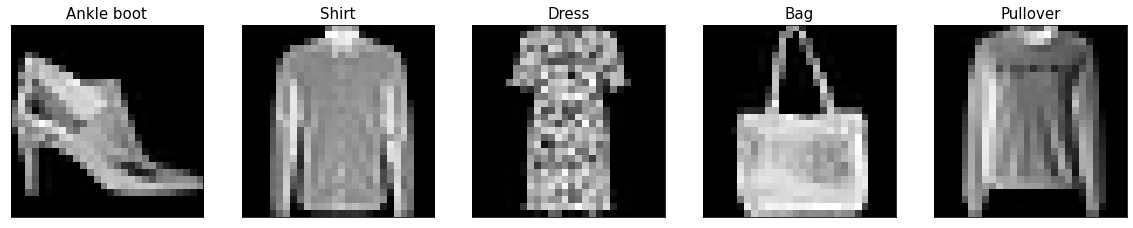

In [66]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

nsamples=5
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
imgs, labels = next(iter(train_loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
print(imgs.size())

In [67]:
size_input = imgs.size()[2]
size_input

28

In [68]:
nb_classes= len(classes_names)

In [69]:
in_scat = imgs[:1,:,:,:]
in_scat.shape

torch.Size([1, 1, 28, 28])

In [70]:
#in_scat = torch.zeros([10, 3, 28, 28])

In [71]:
nb_channels_init = in_scat.shape[1]

In [72]:
nb_channels_init

1

### Scattering

In [73]:
n_space = size_input
nb_channels_in = nb_channels_init

# create scattering
J = scattering_J
L_ang = scat_angles

max_order = 2 if scattering_order2 else 1

if scattering_wph:
    A = scattering_nphases
    scattering = ScatteringTorch2D_wph(J=J, shape=(size_input, size_input), L=L_ang, A=A, max_order=max_order,
                                       backend=backend)
else:
    scattering = Scattering2D(J=J, shape=(size_input, size_input), L=L_ang, max_order=max_order,
                              backend=backend)
# Flatten scattering
scattering = nn.Sequential(scattering, nn.Flatten(1, 2))

if scattering_wph:
    nb_channels_in += nb_channels_init * A * L_ang * J
else:
    nb_channels_in += nb_channels_init * L_ang * J

if max_order == 2:
    nb_channels_in += nb_channels_init * (L_ang ** 2) * J * (J - 1) // 2

n_space = n_space // (2 ** J)

#### visualise

In [74]:
nb_channels_in

33

In [75]:
out_scat = scattering(in_scat)

In [76]:
out_scat.size()

torch.Size([1, 33, 1, 1])

### Linear proj

In [77]:
# create linear proj
# Standardization (can also be performed with BatchNorm2d(affine=False))
if not os.path.exists('standardization'):
    os.makedirs('standardization')
std_file = 'standardization/{}_scattering_J{}_order{}_wph_{}_nphases_{}_nb_classes_{}.pth.tar'.format(dataset_name,
    scattering_J, 2 if scattering_order2 else 1, scattering_wph,
    scattering_nphases if scattering_wph else 0, nb_classes)

if os.path.isfile(std_file):
    print_and_write("=> loading scattering mean and std '{}'".format(std_file), logfile)
    std_dict = torch.load(std_file)
    mean_std = std_dict['mean']
    stding_mat = std_dict['matrix']
else:
    mean_std, stding_mat, std = compute_stding_matrix(train_loader, scattering, logfile)
    print_and_write("=> saving scattering mean and std '{}'".format(std_file), logfile)
    std_dict = {'mean': mean_std, 'std': std, 'matrix': stding_mat}
    torch.save(std_dict, std_file)

standardization = Rescaling(mean_std, stding_mat)
# standardization = nn.BatchNorm2d(nb_channels_in, affine=False)

if arch in ['sparsescatnet', 'sparsescatnetw']:
    print(nb_channels_in)
    proj = nn.Conv2d(nb_channels_in, L_proj_size, kernel_size=L_kernel_size, stride=1,
                     padding=0, bias=False)
    nb_channels_in = L_proj_size
    linear_proj = LinearProj(standardization, proj, L_kernel_size)
else:  # scatnet
    proj = nn.Identity()
    linear_proj = LinearProj(standardization, proj, 0)


Computing mean and standardization matrix...
Starting by computing mean and std dev...
batch: [0/2]
Creating stding matrix...
=> saving scattering mean and std 'standardization/FashionMNIST_scattering_J4_order1_wph_False_nphases_0_nb_classes_10.pth.tar'
33


#### visualize

In [78]:
out_scat.shape

torch.Size([1, 33, 1, 1])

In [79]:
out_proj = linear_proj(out_scat[:,:,0,0])
out_proj

RuntimeError: Argument #6: Padding size should be less than the corresponding input dimension, but got: padding (1, 1) at dimension 2 of input 4

In [112]:
out_proj.size()

torch.Size([1, 256, 10, 513])

### ISTC

In [113]:
if arch in ['sparsescatnet', 'sparsescatnetw']:
###########################################################################################
    if arch == 'sparsescatnet':
        arch_log = "=> creating model SparseScatNet with phase scattering {}, linear projection " \
                   "(projection dimension {}), ISTC with {} iterations, dictionary size {}, classifier {} " \
                   "pipeline".format(scattering_wph, L_proj_size, n_iterations,
                                     dictionary_size, classifier_type)

        istc = ISTC(nb_channels_in, dictionary_size=dictionary_size, n_iterations=n_iterations,
                    lambda_0=lambda_0, lambda_star=lambda_star, lambda_star_lb=lambda_star_lb,
                    grad_lambda_star=grad_lambda_star, epsilon_lambda_0=epsilon_lambda_0,
                    output_rec=output_rec)

    elif arch == 'sparsescatnetw':
        arch_log = "=> creating model SparseScatNetW with phase scattering {}, linear projection " \
                   "(projection dimension {}), ISTCW with {} iterations, dictionary size {}, classifier {} " \
                   "pipeline".format(scattering_wph, L_proj_size, n_iterations,
                                     dictionary_size, classifier_type)

        istc = ISTC(nb_channels_in, dictionary_size=dictionary_size, n_iterations=n_iterations,
                    lambda_0=lambda_0, lambda_star=lambda_star, lambda_star_lb=lambda_star_lb,
                    grad_lambda_star=grad_lambda_star, epsilon_lambda_0=epsilon_lambda_0,
                    output_rec=output_rec, use_W=True)

    if not output_rec:
        nb_channels_in = dictionary_size

elif arch == 'scatnet':
    arch_log = "=> creating model ScatNet with phase scattering {} and classifier {}".\
        format(scattering_wph, classifier_type)

#### visualise

In [114]:
out_istc = istc(out_proj)

In [115]:
out_istc.size()

torch.Size([1, 2048, 10, 513])

### Classifier

In [116]:
classifier = Classifier(n_space, nb_channels_in, classifier_type=classifier_type,
                        nb_classes=nb_classes, nb_hidden_units=nb_hidden_units, nb_l_mlp=nb_l_mlp,
                                dropout_p_mlp=dropout_p_mlp, avg_ker_size=avg_ker_size)

### Create Model

In [117]:
if arch in ['sparsescatnet', 'sparsescatnetw']:
    model = SparseScatNet(scattering, linear_proj, istc, classifier, return_full_inf=True)  # print model info

elif arch == 'scatnet':
    model = nn.Sequential(scattering, linear_proj, classifier)

In [118]:
model(in_scat)

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (1, 1) at dimension 3 of input 4